In [1]:
from __future__ import print_function,division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images,[images.shape[0],-1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    
    fig = plt.figure(figsize=(sqrtn,sqrtn))
    gs = gridspec.GridSpec(sqrtn,sqrtn)
    gs.update(wspace=0.05,hspace=0.05)
    
    for i,img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
        
    return

def preprocess_img(x):
    return 2*x-1.0

def deprocess_img(x):
    return (x+1.0)/2.0

def rel_error(x,y):
    return np.max(np.abs(x-y)/(np.maximum(1e-8,np.abs(x)+np.abs(y))))

def count_params():
    """Count the number of parameters in the current Tensorflow graph"""
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count

answers  = np.load('gan-checks-tf.npz')

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


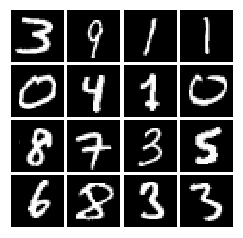

In [4]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data/',one_hot=False)

show_images(mnist.train.next_batch(16)[0])

In [5]:
def leaky_relu(x,alpha=0.01):
    """
    Compute the leaky Relu activation function.
    
    Inputs:
    - x: Tensorflow tensor with arbitrary shape
    - alpha: leak parameter for leaky Relu
    
    Returns:
    TensorFlow tensor with the same shape as x
    """
    
    
    return tf.maximum(x,alpha*x)

In [6]:
def test_leaky_relu(x,y_true):
    tf.reset_default_graph()
    with tf.Session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g' % rel_error(y_true,y))
        
test_leaky_relu(answers['lrelu_x'],answers['lrelu_y'])

Maximum error: 0


In [7]:
def sample_noise(batch_size,dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    
    Returns:
    Tensorflow tensor containing uniform noise in [-1,1] with shape [batch_size,dim]
    """
    
    return tf.random_uniform(shape=[batch_size,dim],minval=-1,maxval=1)

In [8]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with tf.Session() as sess:
        z = sample_noise(batch_size,dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size,dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z,tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1,z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print('All tests passed!')
        
test_sample_noise()

All tests passed!


In [9]:
def discriminator(x):
    """
    Compute discriminator score for a batch of input images.
    
    Inputs:
    TensorFlow Tensor with shape [batch_size,1], containing the score
    for an image being real for each input image.
    """
    with tf.variable_scope('discriminator'):
        input_layer = tf.reshape(x,[-1,784])
        fc1 = tf.layers.dense(inputs=input_layer,units=256,activation=None,use_bias=True)
        lrelu1 = leaky_relu(fc1,0.01)
        fc2 = tf.layers.dense(inputs=lrelu1,units=256,activation=None,use_bias=True)
        lrelu2 = leaky_relu(fc2,0.02)
        logits = tf.layers.dense(inputs=lrelu2,units=1,activation=None,use_bias=True)
        return logits

In [10]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with tf.Session() as sess:
        y = discriminator(tf.ones((2,784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator.{0} instead of {1}. check your architecture.'
                 .format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
            
test_discriminator()

Correct number of parameters in discriminator.


In [11]:
def generator(z):
    """
    Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch,noise_dim]
    
    Returns:
    TensorFlow tensor of generated images, with shape [batch_size,784]
    """
    with tf.variable_scope('generator'):
        fc1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,use_bias=True)
        fc2 = tf.layers.dense(inputs=fc1,units=1024,activation=tf.nn.relu,use_bias=True)
        img = tf.layers.dense(inputs=fc2,units=784,activation=tf.nn.tanh,use_bias=True)
        return img

In [12]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with tf.Session() as sess:
        y = generator(tf.ones((1,4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator.{0} instead of {1}. check your architecture.'
                 .format(cur_count,true_count))
        else:
            print('Correct number of parameters in generetor.')
            
test_generator()

Correct number of parameters in generetor.


In [13]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    
    HINT: for the discriminator loss, you'll want to do the averaging separately for
    its two components, and then add them together (instead of averaging once at the very end).
    """
    # TODO: compute D_loss and G_loss
    labels_ones = tf.ones_like(logits_fake)
    labels_zeros = tf.zeros_like(logits_fake)
    
    # sigmoid_cross_entropy_with_logits = labels * -log(sigmoid(logits)) + (1 - labels) * -log(1-sigmoid(logits))
    # use labels_ones and labels_zeros
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_ones,logits=logits_fake))
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_ones,logits=logits_real)) \
            +tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_zeros,logits=logits_fake))
    
    return D_loss, G_loss

In [14]:
def test_gan_loss(logits_real,logits_fake,d_loss_true,g_loss_true):
    tf.reset_default_graph()
    with tf.Session() as sess:
        d_loss,g_loss = sess.run(gan_loss(tf.constant(logits_real),tf.constant(logits_fake)))
    print('Maximum error in d_loss: %g'% rel_error(d_loss_true,d_loss))
    print('Maximum error in g_loss: %g'% rel_error(g_loss_true,g_loss))
    
test_gan_loss(answers['logits_real'],answers['logits_fake'],answers['d_loss_true'],answers['g_loss_true'])

Maximum error in d_loss: 6.02597e-17
Maximum error in g_loss: 7.19722e-17


In [15]:
def get_solvers(learning_rate=1e-3,beta1=0.5):
    """
    Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers(first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    return D_solver, G_solver

In [16]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [17]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
            
        minibatch,minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step,D_loss],feed_dict={x:minibatch})
        _, G_loss_curr = sess.run([G_train_step,G_loss],feed_dict={x:minibatch})
        
        if it % print_every == 0:
            print('Iter: {},D:{:.4},G{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)
    
    fig = show_images(samples[:16])
    plt.show()

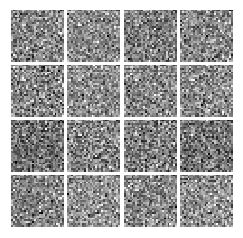


Iter: 0,D:1.155,G0.8028
Iter: 50,D:0.2843,G2.118
Iter: 100,D:2.049,G1.047
Iter: 150,D:1.939,G1.728
Iter: 200,D:1.251,G1.104


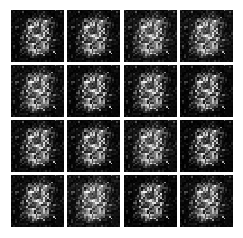


Iter: 250,D:1.652,G0.7485
Iter: 300,D:1.036,G1.463
Iter: 350,D:1.098,G1.425
Iter: 400,D:1.097,G1.425
Iter: 450,D:1.54,G1.416


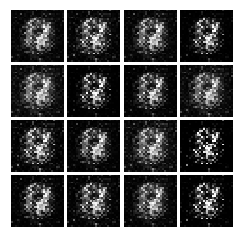


Iter: 500,D:1.16,G1.26
Iter: 550,D:1.328,G1.137
Iter: 600,D:1.153,G1.167
Iter: 650,D:0.8923,G1.821
Iter: 700,D:1.663,G0.6212


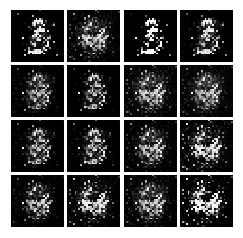


Iter: 750,D:1.464,G2.213
Iter: 800,D:0.9922,G1.227
Iter: 850,D:1.356,G1.129
Iter: 900,D:1.278,G1.419
Iter: 950,D:1.355,G1.062


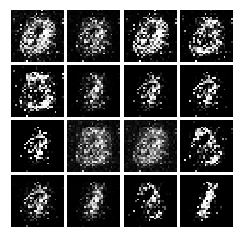


Iter: 1000,D:1.144,G1.608
Iter: 1050,D:0.8509,G0.9006
Iter: 1100,D:1.127,G1.685
Iter: 1150,D:1.184,G0.9553
Iter: 1200,D:1.204,G1.138


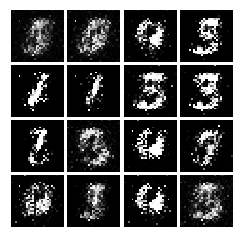


Iter: 1250,D:1.095,G1.444
Iter: 1300,D:1.35,G0.938
Iter: 1350,D:1.127,G1.146
Iter: 1400,D:1.258,G1.03
Iter: 1450,D:1.306,G0.5845


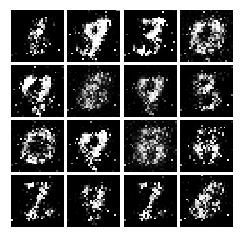


Iter: 1500,D:1.443,G1.101
Iter: 1550,D:1.356,G0.898
Iter: 1600,D:1.271,G0.7399
Iter: 1650,D:1.357,G1.687
Iter: 1700,D:1.694,G1.39


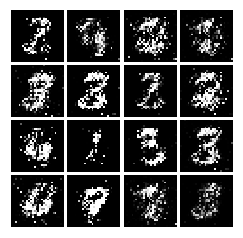


Iter: 1750,D:1.233,G0.9993
Iter: 1800,D:1.152,G1.023
Iter: 1850,D:1.285,G1.064
Iter: 1900,D:1.322,G1.084
Iter: 1950,D:1.285,G0.7855


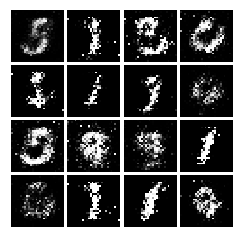


Iter: 2000,D:1.32,G1.873
Iter: 2050,D:1.295,G0.8174
Iter: 2100,D:1.25,G0.9305
Iter: 2150,D:1.494,G0.7591
Iter: 2200,D:1.277,G0.866


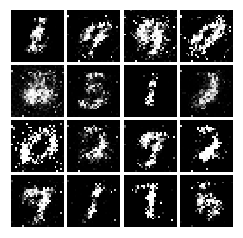


Iter: 2250,D:1.312,G0.6879
Iter: 2300,D:1.289,G0.8872
Iter: 2350,D:1.272,G1.162
Iter: 2400,D:1.261,G0.8608
Iter: 2450,D:1.258,G0.9621


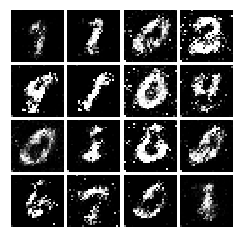


Iter: 2500,D:1.328,G0.9032
Iter: 2550,D:1.415,G0.78
Iter: 2600,D:1.185,G0.821
Iter: 2650,D:1.285,G0.9014
Iter: 2700,D:1.255,G0.8435


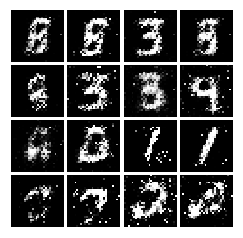


Iter: 2750,D:1.296,G0.8396
Iter: 2800,D:1.368,G0.8634
Iter: 2850,D:1.372,G0.8752
Iter: 2900,D:1.306,G0.8563
Iter: 2950,D:1.302,G0.8187


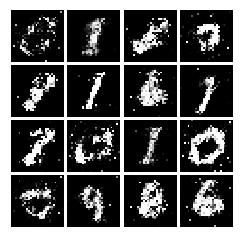


Iter: 3000,D:1.294,G0.7404
Iter: 3050,D:1.377,G0.9116
Iter: 3100,D:1.358,G0.8008
Iter: 3150,D:1.369,G0.7077
Iter: 3200,D:1.323,G0.8118


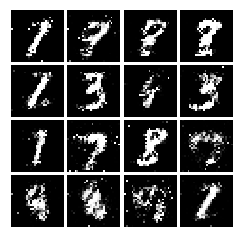


Iter: 3250,D:1.385,G0.9098
Iter: 3300,D:1.459,G0.7374
Iter: 3350,D:1.273,G0.6621
Iter: 3400,D:1.288,G0.8008
Iter: 3450,D:1.35,G0.7702


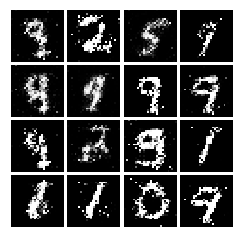


Iter: 3500,D:1.35,G0.8648
Iter: 3550,D:1.298,G0.812
Iter: 3600,D:1.479,G0.6671
Iter: 3650,D:1.316,G0.7746
Iter: 3700,D:1.388,G0.8341


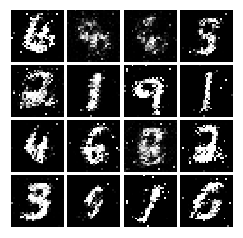


Iter: 3750,D:1.338,G0.808
Iter: 3800,D:1.358,G0.7427
Iter: 3850,D:1.293,G0.8174
Iter: 3900,D:1.315,G0.8998
Iter: 3950,D:1.261,G0.8668


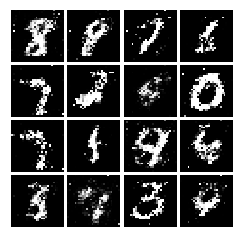


Iter: 4000,D:1.351,G0.7251
Iter: 4050,D:1.286,G0.7879
Iter: 4100,D:1.32,G0.8676
Iter: 4150,D:1.316,G0.8264
Iter: 4200,D:1.328,G0.8327


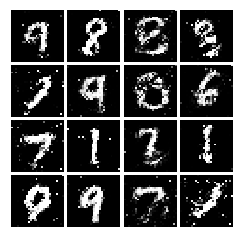


Iter: 4250,D:1.34,G0.6953
Final images


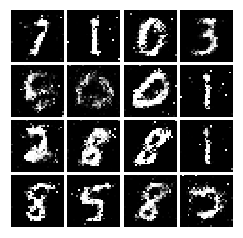

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

In [19]:
def lsgan_loss(score_real,score_fake):
    G_loss = 0.5 * tf.reduce_mean((score_fake-1)**2)
    D_loss = 0.5 * tf.reduce_mean((score_real-1)**2) + 0.5 * tf.reduce_mean(score_fake**2)
    return D_loss,G_loss

In [21]:
def test_lsgan_loss(score_real,score_fake,d_loss_true,g_loss_true):
    with tf.Session() as sess:
        d_loss, g_loss = sess.run(lsgan_loss(tf.constant(score_real),tf.constant(score_fake)))
    print('Maximum error in d_loss: %g' % rel_error(d_loss_true,d_loss))
    print('Maximum error in g_loss: %g' % rel_error(g_loss_true,g_loss))
    
test_lsgan_loss(answers['logits_real'],answers['logits_fake'],answers['d_loss_lsgan_true'],answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


In [22]:
D_loss, G_loss = lsgan_loss(logits_real,logits_fake)
D_train_step = D_solver.minimize(D_loss,var_list=D_vars)
G_train_step = G_solver.minimize(G_loss,var_list=G_vars)

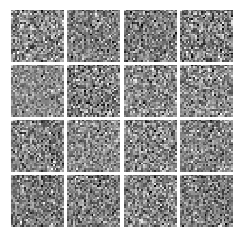


Iter: 0,D:0.3166,G0.4219
Iter: 50,D:0.1657,G0.9923
Iter: 100,D:0.1454,G0.2954
Iter: 150,D:0.06096,G0.4543
Iter: 200,D:0.4613,G0.3132


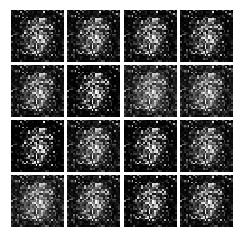


Iter: 250,D:0.05641,G0.7075
Iter: 300,D:0.2807,G0.4092
Iter: 350,D:0.1879,G0.4151
Iter: 400,D:0.2295,G0.2114
Iter: 450,D:0.1175,G0.2485


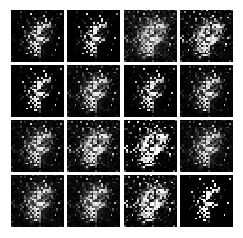


Iter: 500,D:0.08429,G0.5928
Iter: 550,D:0.1166,G0.33
Iter: 600,D:0.3113,G0.1246
Iter: 650,D:0.07088,G0.4204
Iter: 700,D:0.1218,G0.4018


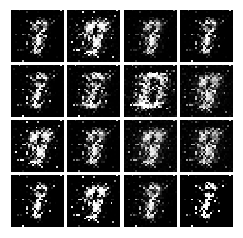


Iter: 750,D:0.1122,G0.5176
Iter: 800,D:0.2007,G0.4425
Iter: 850,D:0.09706,G0.5002
Iter: 900,D:0.1042,G0.3818
Iter: 950,D:0.1667,G0.3186


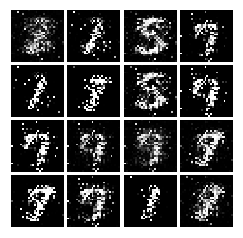


Iter: 1000,D:0.1411,G0.2505
Iter: 1050,D:0.2584,G0.7783
Iter: 1100,D:0.5071,G0.4199
Iter: 1150,D:0.1284,G0.2741
Iter: 1200,D:0.1323,G0.3087


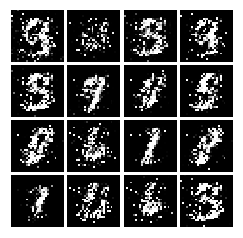


Iter: 1250,D:0.1715,G0.3374
Iter: 1300,D:0.1458,G0.2263
Iter: 1350,D:0.1939,G0.08961
Iter: 1400,D:0.1653,G0.2882
Iter: 1450,D:0.1547,G0.2583


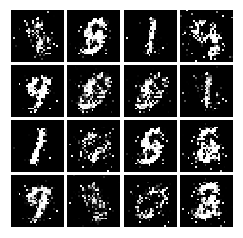


Iter: 1500,D:0.1705,G0.2558
Iter: 1550,D:0.1593,G0.2745
Iter: 1600,D:0.1604,G0.2241
Iter: 1650,D:0.1835,G0.241
Iter: 1700,D:0.1703,G0.2963


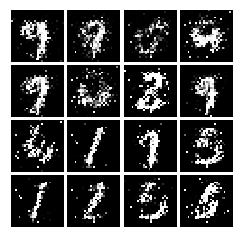


Iter: 1750,D:0.1721,G0.2558
Iter: 1800,D:0.1788,G0.2318
Iter: 1850,D:0.1963,G0.2283
Iter: 1900,D:0.1923,G0.2985
Iter: 1950,D:0.1954,G0.2205


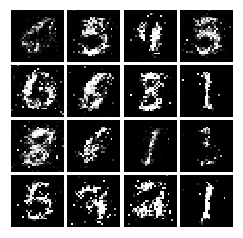


Iter: 2000,D:0.1981,G0.2537
Iter: 2050,D:0.1829,G0.2401
Iter: 2100,D:0.2123,G0.3082
Iter: 2150,D:0.2025,G0.1881
Iter: 2200,D:0.226,G0.1839


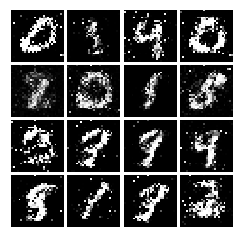


Iter: 2250,D:0.2326,G0.2282
Iter: 2300,D:0.2149,G0.1939
Iter: 2350,D:0.2155,G0.189
Iter: 2400,D:0.2303,G0.2199
Iter: 2450,D:0.2326,G0.2095


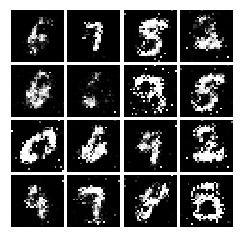


Iter: 2500,D:0.2068,G0.161
Iter: 2550,D:0.226,G0.1879
Iter: 2600,D:0.2158,G0.1939
Iter: 2650,D:0.2236,G0.1756
Iter: 2700,D:0.2196,G0.1926


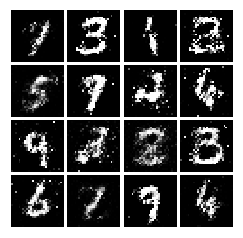


Iter: 2750,D:0.2241,G0.1941
Iter: 2800,D:0.2221,G0.1708
Iter: 2850,D:0.2034,G0.1641
Iter: 2900,D:0.222,G0.202
Iter: 2950,D:0.2132,G0.2097


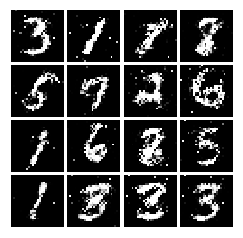


Iter: 3000,D:0.2134,G0.1931
Iter: 3050,D:0.2249,G0.1896
Iter: 3100,D:0.2272,G0.1895
Iter: 3150,D:0.2203,G0.2001
Iter: 3200,D:0.2296,G0.1805


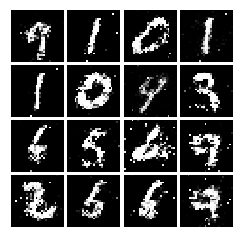


Iter: 3250,D:0.2243,G0.2267
Iter: 3300,D:0.2301,G0.2176
Iter: 3350,D:0.2252,G0.1989
Iter: 3400,D:0.2252,G0.1844
Iter: 3450,D:0.2292,G0.1857


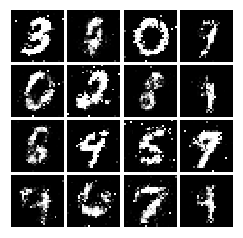


Iter: 3500,D:0.2053,G0.1956
Iter: 3550,D:0.2157,G0.1657
Iter: 3600,D:0.2366,G0.1969
Iter: 3650,D:0.2068,G0.1573
Iter: 3700,D:0.2191,G0.1731


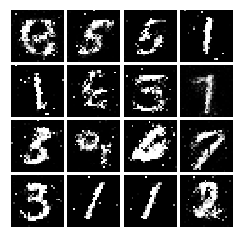


Iter: 3750,D:0.2163,G0.181
Iter: 3800,D:0.2403,G0.1593
Iter: 3850,D:0.2293,G0.173
Iter: 3900,D:0.2273,G0.1818
Iter: 3950,D:0.202,G0.1997


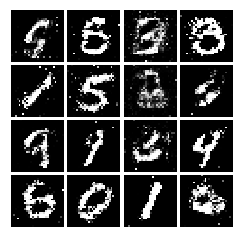


Iter: 4000,D:0.2122,G0.1746
Iter: 4050,D:0.2441,G0.1666
Iter: 4100,D:0.2196,G0.1755
Iter: 4150,D:0.2074,G0.1661
Iter: 4200,D:0.2192,G0.1717


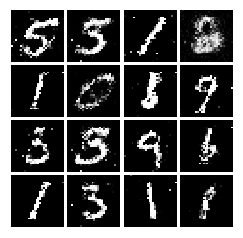


Iter: 4250,D:0.223,G0.179
Final images


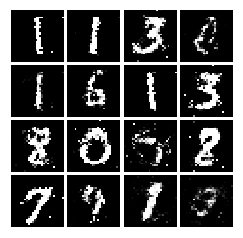

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

In [27]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        input_layer = tf.reshape(x,[-1,28,28,1])
        conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=5,strides=1,activation=None,padding='valid')
        lrelu1 = leaky_relu(conv1,0.01)
        pool1 = tf.layers.max_pooling2d(inputs=lrelu1,pool_size=2,strides=2)
        
        conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=5,strides=1,activation=None,padding='valid')
        lrelu2 = leaky_relu(conv2,0.01)
        pool2 = tf.layers.max_pooling2d(inputs=lrelu2,pool_size=2,strides=2)
        
        pool2_flat = tf.reshape(pool2,[-1,4*4*64])
        dense3 = tf.layers.dense(inputs=pool2_flat,units=4*4*64,activation=None)
        lrelu3 = leaky_relu(dense3,0.01)
        logits = tf.layers.dense(inputs=lrelu3,units=1,activation=None)
        return logits

test_discriminator(1102721)

Correct number of parameters in discriminator.


In [29]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,use_bias=True)
        bn1 = tf.layers.batch_normalization(inputs=fc1,axis=1)
        fc2 = tf.layers.dense(inputs=bn1,units=7*7*128,activation=tf.nn.relu,use_bias=True)
        bn2 = tf.layers.batch_normalization(inputs=fc2,axis=1)
        bn2_resize = tf.reshape(bn2,[-1,7,7,128])
        conv3 = tf.layers.conv2d_transpose(inputs=bn2_resize,filters=64,kernel_size=4,strides=2,activation=tf.nn.relu,
                                 padding='same',use_bias=True)
        bn3 = tf.layers.batch_normalization(inputs=conv3,axis=3)
        img = tf.layers.conv2d_transpose(inputs=bn3,filters=1,kernel_size=4,strides=2,activation=tf.nn.tanh,
                                         padding='same',use_bias=True)
        
        return img
test_generator(6595521)

Correct number of parameters in generetor.


In [30]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

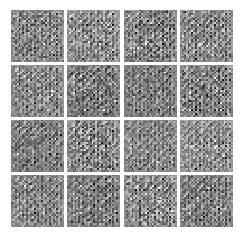


Iter: 0,D:1.368,G0.6532
Iter: 50,D:0.002223,G6.212
Iter: 100,D:0.0003935,G7.939
Iter: 150,D:0.0003374,G8.1
Iter: 200,D:0.006427,G5.203


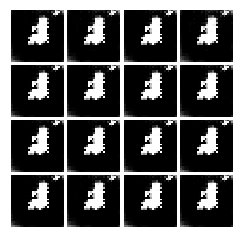


Iter: 250,D:0.7055,G3.202
Iter: 300,D:0.03164,G5.17
Iter: 350,D:0.06744,G3.249
Iter: 400,D:0.002918,G6.18
Iter: 450,D:0.001341,G7.268


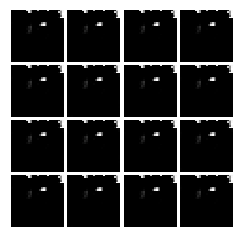


Iter: 500,D:0.001305,G7.788
Iter: 550,D:2.197,G2.264
Iter: 600,D:0.8511,G2.148
Iter: 650,D:1.006,G2.144
Iter: 700,D:0.5258,G2.98


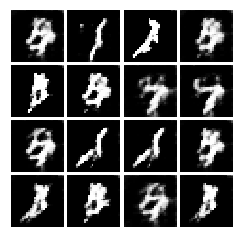


Iter: 750,D:0.8017,G1.974
Iter: 800,D:0.812,G2.921
Iter: 850,D:0.586,G2.989
Iter: 900,D:0.6879,G2.402
Iter: 950,D:0.4875,G2.52


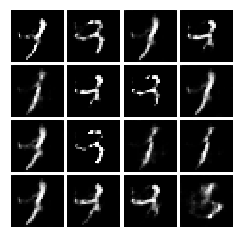


Iter: 1000,D:0.7806,G2.951
Iter: 1050,D:0.501,G4.707
Iter: 1100,D:0.5011,G2.585
Iter: 1150,D:0.7376,G2.965
Iter: 1200,D:0.5971,G2.295


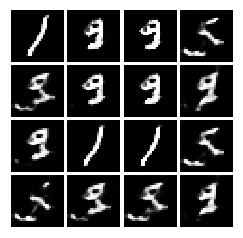


Iter: 1250,D:0.3785,G3.402
Final images


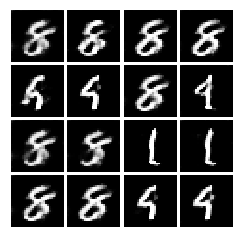

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=3)